In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import PIL
from os import listdir
from skimage import filters
from skimage import feature
import sklearn
from sklearn import metrics
from skimage import measure
import re
%matplotlib inline

In [2]:
dataname = 'ZM_02Pos1'
path = '20171021_ImageSequences_cTY31/ZM_02Pos1/'

In [3]:
fnames = listdir(path)
fnames = np.sort(fnames)

In [4]:
dat = []
for i in range(len(fnames)):
    try:
        img = plt.imread(path+fnames[i])
        tpoint = re.findall('\_t(\d*)',fnames[i])[0]
        z = re.findall('\_z(\d*)',fnames[i])[0]
        ch = np.int(re.findall('\_c(\d*)',fnames[i])[0])
        if ch==1:
            ch = '488'
        elif ch==2:
            ch = '560'
        
        dat.append(dict(tpoint=np.int(tpoint),ch=ch,z=np.int(z),image=np.double(img),filename=fnames[i]))
    except OSError:
        continue
        
df = pd.DataFrame(dat)
df.head()

,ch,filename,image,tpoint,z
0,488,ZM_02Pos1_t001_z001_c001.tif,"[[1676.0, 1549.0, 1556.0, 1554.0, 1537.0, 1561...",1,1
1,560,ZM_02Pos1_t001_z001_c002.tif,"[[1604.0, 1688.0, 1539.0, 1588.0, 1583.0, 1556...",1,1
2,488,ZM_02Pos1_t001_z002_c001.tif,"[[1545.0, 1522.0, 1541.0, 1524.0, 1550.0, 1626...",1,2
3,560,ZM_02Pos1_t001_z002_c002.tif,"[[1922.0, 1568.0, 1607.0, 1621.0, 1535.0, 1615...",1,2
4,488,ZM_02Pos1_t001_z003_c001.tif,"[[1546.0, 1544.0, 1643.0, 1578.0, 1568.0, 1533...",1,3


In [5]:
dat_combined = []
df_grouped = df.groupby(['tpoint','z'])
for t,z in list(df_grouped.indices.keys()):
    gr = df_grouped.get_group((t,z))
    colnames = np.concatenate((['tpoint','z'],'image'+gr['ch'].values,'filename'+gr['ch'].values),axis=0)
    dd = np.concatenate(([t,z],gr['image'].values,gr['filename'].values),axis=0)
    dat_combined.append(dict(zip(colnames,dd)))
    
df_combined = pd.DataFrame(dat_combined)

In [6]:
df_combined.dropna(inplace=True)
df_combined = df_combined.sort(['tpoint','z'])
df_combined.reset_index(inplace=True)
df_combined.drop('index',inplace=True,axis=1)

/Users/tyyoo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [7]:
df_combined.head(3)

,filename488,filename560,image488,image560,tpoint,z
0,ZM_02Pos1_t001_z001_c001.tif,ZM_02Pos1_t001_z001_c002.tif,"[[1676.0, 1549.0, 1556.0, 1554.0, 1537.0, 1561...","[[1604.0, 1688.0, 1539.0, 1588.0, 1583.0, 1556...",1,1
1,ZM_02Pos1_t001_z002_c001.tif,ZM_02Pos1_t001_z002_c002.tif,"[[1545.0, 1522.0, 1541.0, 1524.0, 1550.0, 1626...","[[1922.0, 1568.0, 1607.0, 1621.0, 1535.0, 1615...",1,2
2,ZM_02Pos1_t001_z003_c001.tif,ZM_02Pos1_t001_z003_c002.tif,"[[1546.0, 1544.0, 1643.0, 1578.0, 1568.0, 1533...","[[1729.0, 1531.0, 1560.0, 1556.0, 1528.0, 1532...",1,3


In [8]:
import pims
import trackpy as tp

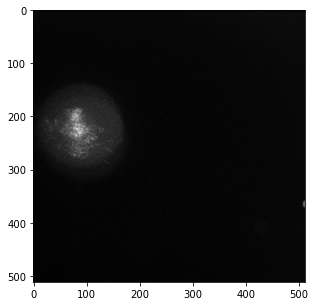

In [9]:
fig = plt.figure(figsize=(5,5))
ax = plt.imshow(df_combined['image488'].sum(),cmap='gray')

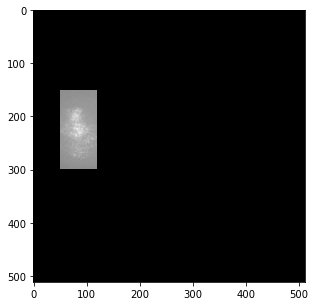

In [23]:
#set ROI
xc=50
yc=150
w = 70
h = 150
ROI = np.zeros_like(dat[0]['image'])
ROI[yc:(yc+h),xc:(xc+w)] = 1

fig = plt.figure(figsize=(5,5))
ax = plt.imshow(df_combined['image488'].sum()*ROI,cmap='gray')

(150, 300)

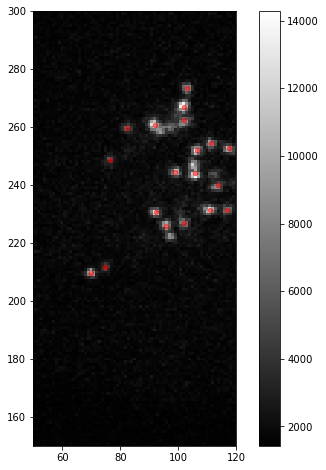

In [26]:
ind = 0
minmass=10000
thres = 95
dia = 7
sep = 4

f = tp.locate(df_combined.iloc[ind]['image488'],dia,percentile=thres,engine='python',
              topn=40,minmass=minmass,separation=sep,)
A = f[['x','y']].values
f

fig = plt.figure(figsize=(8,8))
ax = plt.imshow(df_combined.iloc[ind]['image488'],cmap='gray')
plt.scatter(A[:,0],A[:,1],20,color='r',alpha=0.5)
plt.colorbar(ax)
plt.xlim([xc,(xc+w)])
plt.ylim([yc,(yc+h)])

In [27]:
f['mass']

0     59577.755570
1     12661.586501
2     43947.788831
3     25664.668074
4     50751.421412
5     63675.696429
6     28606.779460
7     30918.438407
8     42870.765913
9     74472.194463
10    19228.799417
11    43343.605243
12    42476.733138
13    32047.999028
14    26058.700849
15    87186.318667
16    44867.198639
17    79463.276279
18    36907.736586
Name: mass, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a0e7eb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13a308668>]], dtype=object)

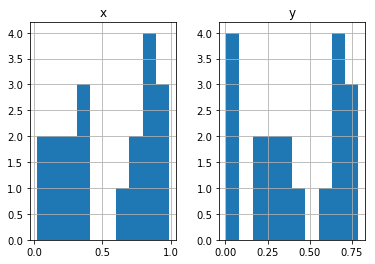

In [28]:
tp.subpx_bias(f)

In [29]:
def imshow_2col(image1,image2,feat=None):
    #normalize
    image1 = (image1-np.min(image1,axis=None))/(np.max(image1,axis=None)-np.min(image1,axis=None))
    image2 = (image2-np.min(image2,axis=None))/(np.max(image2,axis=None)-np.min(image2,axis=None))
    M = np.dstack((image2,image1,np.zeros(np.shape(image1))))
    plt.imshow(M)
    if feat is not None:
        x = feat['x'].values
        y = feat['y'].values
        size = feat['size'].values
        kinid = feat['kinid'].values
        plt.scatter(x,y,50,color='w',marker='o',facecolors='none',linewidths=2,alpha=0.6)
        for i in range(len(x)):
            plt.text(x[i]-1,y[i]-1,kinid[i],fontdict={'size':14,'color':'blue','weight':'bold'})

In [30]:
df_feat = tp.batch(df_combined['image488'].values,dia,percentile=thres,engine='python',topn=40,minmass=minmass,separation=sep)

Frame 98: 11 features


In [31]:
#reject kinetochores outside ROI
df_feat = df_feat.drop(df_feat.loc[(df_feat['x']<xc) | (df_feat['x']>xc+w) | (df_feat['y']<yc) | (df_feat['y']>yc+h)].index)
df_feat = df_feat.set_index(np.arange(df_feat.shape[0]))
df_feat.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame
0,70.019400,209.769841,59577.755570,1.661102,0.134809,5674.071959,133316.0,0.006415,0
1,74.744813,211.653527,12661.586501,1.662373,0.193694,1234.636028,78426.0,0.016987,0
2,95.918111,225.789600,43947.788831,1.698950,0.106154,4176.747414,140858.0,0.005910,0
3,101.987718,227.008188,25664.668074,1.558153,0.115404,2679.422870,121617.0,0.007396,0
4,92.225155,230.653727,50751.421412,1.588976,0.141991,5122.426074,139909.0,0.005969,0


In [32]:

df_feat['kinid'] = df_feat.index
df_feat_grp = df_feat.groupby('frame')
df_feat['kinid'] = df_feat['kinid'] - df_feat_grp.first().ix[df_feat['frame'],'kinid'].values


In [33]:
tpoints = df_feat[['frame']].applymap(lambda x:df_combined.iloc[x]['tpoint'])
tpoints.columns = ['tpoint']
zs = df_feat[['frame']].applymap(lambda x:df_combined.iloc[x]['z'])
zs.columns = ['z']
df_feat = pd.concat((df_feat,tpoints,zs),axis=1)

In [34]:
df_feat.head(10)

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,kinid,tpoint,z
0,70.019400,209.769841,59577.755570,1.661102,0.134809,5674.071959,133316.0,0.006415,0,0,1,1
1,74.744813,211.653527,12661.586501,1.662373,0.193694,1234.636028,78426.0,0.016987,0,1,1,1
2,95.918111,225.789600,43947.788831,1.698950,0.106154,4176.747414,140858.0,0.005910,0,2,1,1
3,101.987718,227.008188,25664.668074,1.558153,0.115404,2679.422870,121617.0,0.007396,0,3,1,1
4,92.225155,230.653727,50751.421412,1.588976,0.141991,5122.426074,139909.0,0.005969,0,4,1,1
5,110.819307,231.391089,63675.696429,1.732051,0.190364,5437.652294,159076.0,0.004965,0,5,1,1
6,116.860422,231.378329,28606.779460,1.659212,0.158073,2731.960573,110751.0,0.008621,0,6,1,1
7,113.770603,240.071368,30918.438407,1.709089,0.142257,2731.960573,123586.0,0.007211,0,7,1,1
8,98.974877,244.436887,42870.765913,1.585009,0.173227,4413.167079,138478.0,0.006060,0,8,1,1
9,105.652910,244.230335,74472.194463,1.786388,0.062963,5831.685069,186383.0,0.004005,0,9,1,1


In [35]:
#find metaphase plate slope (mps) using linear regression (or pca)
from sklearn import linear_model
from sklearn.decomposition import PCA

tpoints = np.unique(df_feat.tpoint.values)

for t in tpoints:
    #regr = linear_model.LinearRegression()
    #regr.fit(df_feat[df_feat.tpoint==t]['x'].values.reshape(-1,1),df_feat[df_feat.tpoint==t]['y'].values)
    #df_feat.ix[df_feat.tpoint==t,'mps'] = regr.coef_
    
    pcaobj = PCA()
    pcaobj.fit(df_feat[df_feat.tpoint==t][['x','y']].values)
    #print(pcaobj.components_[0])
    df_feat.ix[df_feat.tpoint==t,'mps'] = pcaobj.components_[0][1]/pcaobj.components_[0][0]

In [36]:
#distance along a vector
def dist_par(loc1,loc2,vec):
    return np.abs(np.inner(loc2-loc1,vec/np.linalg.norm(vec)))

#distance in a perpendicular direction
def dist_perp(loc1,loc2,vec):
    return np.sqrt(np.linalg.norm(loc2-loc1)**2-dist_par(loc1,loc2,vec)**2)

In [46]:
#pairwise distance
fr=23
feat_selected = df_feat[df_feat.frame==fr]
d_par = metrics.pairwise.pairwise_distances(feat_selected[['x','y']].values,
                                              metric=dist_par,vec=[1,feat_selected.iloc[0]['mps']])
d_perp = metrics.pairwise.pairwise_distances(feat_selected[['x','y']].values,
                                              metric=dist_perp,vec=[1,feat_selected.iloc[0]['mps']])
#fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
#im = ax[0].imshow(d_par)
#fig.colorbar(im,ax=ax[0],fraction=0.046, pad=0.04)
#im = ax[1].imshow(d_perp)
#fig.colorbar(im,ax=ax[1],fraction=0.046, pad=0.04)


(150, 300)

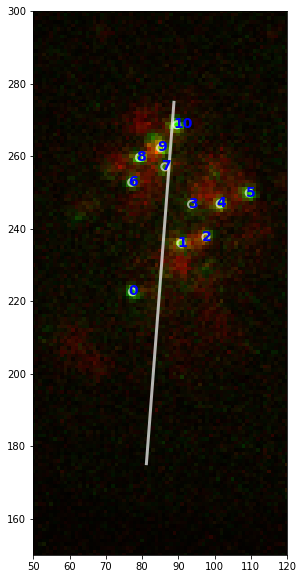

In [47]:
#test
selected = df_combined.iloc[fr].copy()
#print(selected.tpoint,selected.z)
plt.figure(figsize=(10,10))
imshow_2col(selected['image488'],selected['image560'],df_feat[df_feat.frame==fr])
mps = df_feat.loc[df_feat.frame==fr]['mps'].values[0]
vec = [1,mps]/np.linalg.norm([1,mps])
#print(vec)
l = 100
plt.plot(np.linspace(xc+w/2-vec[0]*l/2,xc+w/2+vec[0]*l/2),
         np.linspace(yc+h/2-vec[1]*l/2,yc+h/2+vec[1]*l/2),'w',lw=3,alpha=0.7)
plt.xlim([xc,(xc+w)])
plt.ylim([yc,(yc+h)])

In [48]:
### kinetochore pairing test
d_par = np.triu(d_par)
d_perp = np.triu(d_perp)

cand = np.where((d_par<2.9) & (d_par>0) & (d_perp>3.5) & (d_perp<13))

cand
#print(np.where(cand==dups[0]))
#print(cand)

(array([1, 3, 7]), array([2, 4, 8]))

In [ ]:
### kinetochore pairing 
range_d_par = [0,2.9]
range_d_perp = [3.5,13]

df_feat['sister_id'] = -1

for fr in df_combined.index:
    #print(fr)
    feat_selected = df_feat[df_feat.frame==fr]
    if len(feat_selected)==0:
        continue
    #pairwise distances
    d_par = metrics.pairwise.pairwise_distances(feat_selected[['x','y']].values,
                                                  metric=dist_par,vec=[1,feat_selected.iloc[0]['mps']])
    d_perp = metrics.pairwise.pairwise_distances(feat_selected[['x','y']].values,
                                                  metric=dist_perp,vec=[1,feat_selected.iloc[0]['mps']])
    d_par = np.triu(d_par)
    d_perp = np.triu(d_perp)
    
    #find kinetochore pair candidates
    cand = np.where((d_par<range_d_par[1]) & (d_par>range_d_par[0]) 
                    & (d_perp>range_d_perp[0]) & (d_perp<range_d_perp[1]))
    #find and get rid of duplicates
    dups=np.where(np.diff(np.sort(np.concatenate(cand)))==0)[0]
    ind_dups = np.where(cand==dups[0])[1] if dups.any() else []
    ind_nodups = [x for x in range(len(cand[0])) if not x in ind_dups]

    cand_nodups = (cand[0][ind_nodups],cand[1][ind_nodups])
    
    for i,id1 in enumerate(cand_nodups[0]):
        id2 = cand_nodups[1][i]
        df_feat.loc[(df_feat['frame']==fr) & (df_feat['kinid']==id1),'sister_id']=id2
        df_feat.loc[(df_feat['frame']==fr) & (df_feat['kinid']==id2),'sister_id']=id1
    

In [ ]:
#generate line that pass through two points. 
#loc1, loc2: (x,y) locations
#l: length
def generateLine(loc1,loc2,l):
    l = float(l)
    v = loc2-loc1
    u = v/np.linalg.norm(v)
    cen = (loc1+loc2)/2.0
    return [cen-u*l/2.0,cen+u*l/2.0]
    

In [ ]:
dic_prof = []

tpoint_selection = np.unique(df_feat.tpoint.values)
linelen = 30
#linewidth = 2
linewidth = 1

feat_sel = df_feat.loc[[t in tpoint_selection for t in df_feat.tpoint]]
feat_sel_grp = feat_sel.groupby(('tpoint','frame'))
for key in feat_sel_grp.groups.keys():
    grp = feat_sel_grp.get_group(key)
    pairs = grp[['kinid','sister_id']].values
    if not pairs.any():
        continue
    
    #remove -1's and duplicates
    pairs = [r for r in pairs if r[1]!=-1]
    if not pairs:
        continue
    pairs = np.sort(pairs,axis=1)
    pairs = [tuple(r) for r in pairs]
    pairs = np.sort(pairs,axis=0)[::2]
    
    selected = df_combined.loc[(df_combined['tpoint']==key[0]) & (df_combined.index==key[1])]
    for pair in pairs:
        locs = grp.loc[(grp['kinid']==pair[0]) | (grp['kinid']==pair[1]),['y','x']].values
        line = generateLine(locs[0],locs[1],linelen)
        
        prof488 = measure.profile_line(selected['image488'].values[0],line[0],line[1],linewidth=linewidth)
        prof560 = measure.profile_line(selected['image560'].values[0],line[0],line[1],linewidth=linewidth)
        
        prof488 = prof488[:int(np.ceil(linelen))+1]
        prof560 = prof560[:int(np.ceil(linelen))+1]
        
        dic_prof.append({'tpoint':key[0],'fr':key[1],'kinid1':pair[0],'kinid2':pair[1]
                         ,'prof488':prof488,'prof560':prof560})


df_prof = pd.DataFrame(dic_prof)

In [ ]:
# Remove abnormal profiles

# add kkdist
kkdists = []
for i in df_prof.index:
    ids = df_prof.iloc[i][['kinid1','kinid2']].values
    fr = df_prof.iloc[i]['fr']
    feat_sel = df_feat.loc[(df_feat['frame']==fr) & ((df_feat['kinid']==ids[0]) | (df_feat['kinid']==ids[1]))]
    kkdists.append(np.linalg.norm(np.diff(feat_sel[['x','y']].values,axis=0)))

df_prof['kkdist'] = kkdists

proflen = len(df_prof.iloc[0]['prof560'])
x = np.arange(proflen)-(proflen-1)/2.0

# 560 intensity between kinetochores and outside the pair
int560in = df_prof.apply(lambda row: np.mean(row.prof560[(x>-row.kkdist/2.0) & (x<row.kkdist/2.0)]),axis=1)
int560out = df_prof.apply(lambda row: np.mean(row.prof560[(x<-row.kkdist/2.0) | (x>row.kkdist/2.0)]),axis=1)

df_prof = df_prof.loc[int560in>int560out]

In [ ]:
df_prof.shape

In [ ]:
trange2 = range(4,7)

df_prof_sel = df_prof.loc[[t in trange2 for t in df_prof['tpoint']]]

fig,ax1=plt.subplots(figsize=(15,15))
ax2 = ax1.twinx()

N = len(df_prof_sel.index)

for i in range(N):
    ax1.plot(df_prof_sel.iloc[i]['prof488'],'g',alpha=0.1)
    ax2.plot(df_prof_sel.iloc[i]['prof560'],'r',alpha=0.1)
    
prof488_std = np.std(df_prof_sel.prof488.values,axis=0)/np.sqrt(N)
prof560_std = np.std(df_prof_sel.prof560.values,axis=0)/np.sqrt(N)
prof488_mean = np.mean(df_prof_sel.prof488.values,axis=0)
prof560_mean = np.mean(df_prof_sel.prof560.values,axis=0)

ax1.fill_between(range(int(np.ceil(linelen)+1)),prof488_mean+2*prof488_std,prof488_mean-2*prof488_std,color='g',alpha=0.7)
ax2.fill_between(range(int(np.ceil(linelen)+1)),prof560_mean+2*prof560_std,prof560_mean-2*prof560_std,color='r',alpha=0.7)

plt.title('From t%d to t%d' % (trange2[0],trange2[-1]))

fig.savefig(dataname+'_t%dto%d.png' % (trange2[0],trange2[-1]),format='png')

prof488_mean2 = prof488_mean
prof560_mean2 = prof560_mean
prof488_std2 = prof488_std
prof560_std2 = prof560_std

In [ ]:
trange1 = range(1,4)

df_prof_sel = df_prof.loc[[t in trange1 for t in df_prof['tpoint']]]

fig,ax1=plt.subplots(figsize=(15,15))
ax2 = ax1.twinx()

N = len(df_prof_sel.index)

for i in range(N):
    ax1.plot(df_prof_sel.iloc[i]['prof488'],'g',alpha=0.1)
    ax2.plot(df_prof_sel.iloc[i]['prof560'],'r',alpha=0.1)
    
prof488_std = np.std(df_prof_sel.prof488.values,axis=0)/np.sqrt(N)
prof560_std = np.std(df_prof_sel.prof560.values,axis=0)/np.sqrt(N)
prof488_mean = np.mean(df_prof_sel.prof488.values,axis=0)
prof560_mean = np.mean(df_prof_sel.prof560.values,axis=0)

ax1.fill_between(range(int(np.ceil(linelen)+1)),prof488_mean+2*prof488_std,prof488_mean-2*prof488_std,color='g',alpha=0.7)
ax2.fill_between(range(int(np.ceil(linelen)+1)),prof560_mean+2*prof560_std,prof560_mean-2*prof560_std,color='r',alpha=0.7)

plt.title('From t%d to t%d' % (trange1[0],trange1[-1]))

fig.savefig(dataname+'_t%dto%d.png' % (trange1[0],trange1[-1]),format='png')

prof488_mean1 = prof488_mean
prof560_mean1 = prof560_mean
prof488_std1 = prof488_std
prof560_std1 = prof560_std

In [ ]:
trange3 = range(7,10)

df_prof_sel = df_prof.loc[[t in trange3 for t in df_prof['tpoint']]]

fig,ax1=plt.subplots(figsize=(15,15))
ax2 = ax1.twinx()

N = len(df_prof_sel.index)

for i in range(N):
    ax1.plot(df_prof_sel.iloc[i]['prof488'],'g',alpha=0.1)
    ax2.plot(df_prof_sel.iloc[i]['prof560'],'r',alpha=0.1)
    
prof488_std = np.std(df_prof_sel.prof488.values,axis=0)/np.sqrt(N)
prof560_std = np.std(df_prof_sel.prof560.values,axis=0)/np.sqrt(N)
prof488_mean = np.mean(df_prof_sel.prof488.values,axis=0)
prof560_mean = np.mean(df_prof_sel.prof560.values,axis=0)

ax1.fill_between(range(int(np.ceil(linelen)+1)),prof488_mean+2*prof488_std,prof488_mean-2*prof488_std,color='g',alpha=0.7)
ax2.fill_between(range(int(np.ceil(linelen)+1)),prof560_mean+2*prof560_std,prof560_mean-2*prof560_std,color='r',alpha=0.7)

plt.title('From t%d to t%d' % (trange3[0],trange3[-1]))

fig.savefig(dataname+'_t%dto%d.png' % (trange3[0],trange3[-1]),format='png')

prof488_mean3 = prof488_mean
prof560_mean3 = prof560_mean
prof488_std3 = prof488_std
prof560_std3 = prof560_std

In [ ]:
#save analyzed data
df_feat.to_csv(dataname+'_feat.csv')
df_prof.to_csv(dataname+'_prof.csv')

In [ ]:
fig,ax1=plt.subplots(figsize=(7,9))
ax2 = ax1.twinx()

ax1.fill_between(range(int(np.ceil(linelen)+1)),
                 prof488_mean1+2*prof488_std1,prof488_mean1-2*prof488_std1,color='g',alpha=0.7,hatch='//')
ax2.fill_between(range(int(np.ceil(linelen)+1)),prof560_mean1+2*prof560_std1,prof560_mean1-2*prof560_std1,color='r',alpha=0.7,hatch='//')

ax1.fill_between(range(int(np.ceil(linelen)+1)),
                 prof488_mean2+2*prof488_std2,prof488_mean2-2*prof488_std2,color='g',alpha=0.7,hatch='o')
ax2.fill_between(range(int(np.ceil(linelen)+1)),prof560_mean2+2*prof560_std2,prof560_mean2-2*prof560_std2,color='r',alpha=0.7,hatch='o')

ax1.fill_between(range(int(np.ceil(linelen)+1)),
                 prof488_mean3+2*prof488_std3,prof488_mean3-2*prof488_std3,color='g',alpha=0.7,hatch='^')
ax2.fill_between(range(int(np.ceil(linelen)+1)),prof560_mean3+2*prof560_std3,prof560_mean3-2*prof560_std3,color='r',alpha=0.7,hatch='^')


ax1.tick_params('y',color='g')
ax2.tick_params('y',color='r')
ax1.set_ylabel('GFP-CENPA',color='g')
ax2.set_ylabel('mCherry-INCENP',color='r')

plt.title('t%d~%d vs t%d~t%d vs t%d~t%d' %(trange1[0],trange1[-1],trange2[0],trange2[-1],trange3[0],trange3[-1]))

fig.savefig(dataname+'_overlaid.png',format='png')